# Louisiana House District 90 Democratic Voters

### Importing Libraries and Data

In [1]:
#Import libraries
import itertools

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

C:\Users\miran\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#Import CSV
data = pd.read_csv('LA House District 090 Dems - Clean.csv', index_col='INDEX')

In [3]:
#Check data
data.head()

,"HOU,C,3","PSH,C,5","PARISH,N,2,0","TYPE,C,4","CITY,C,17","STATE,C,2","ZIP,C,5","AGE,C,3","GENDER,C,1","RACE,C,1","PARTY_ID,C,1","VOTE_FREQ,C,1","PPP,C,1 (P for presidential primary)","NEW,C,1","How they vote (in person, mail, early)","MAIL_CITY,C,28","MAIL_STATE,C,20","MAIL_ZIP,C,5"
INDEX,,,,,,,,,,,,,,,,,,
1,90,StTam,52,Land,PEARL RIVER,LA,70452,40,M,W,D,7,P,NaN,I,PEARL RIVER,LA,70452
2,90,StTam,52,Cell,PEARL RIVER,LA,70452,58,F,B,D,A,P,NaN,E,PEARL RIVER,LA,70452
3,90,StTam,52,NaN,SLIDELL,LA,70458,28,F,W,D,3,P,NaN,M,SLIDELL,LA,70458
4,90,StTam,52,NaN,SLIDELL,LA,70458,41,F,W,D,1,NaN,NaN,E,SLIDELL,LA,70458
5,90,StTam,52,Land,PEARL RIVER,LA,70452,75,M,B,D,4,P,NaN,E,PEARL RIVER,LA,70452


### Initial Data Cleaning

In [4]:
#Checking data types
data.dtypes

HOU,C,3                                    int64
PSH,C,5                                   object
PARISH,N,2,0                               int64
TYPE,C,4                                  object
CITY,C,17                                 object
STATE,C,2                                 object
ZIP,C,5                                    int64
AGE,C,3                                    int64
GENDER,C,1                                object
RACE,C,1                                  object
PARTY_ID,C,1                              object
VOTE_FREQ,C,1                             object
PPP,C,1 (P for presidential primary)      object
NEW,C,1                                   object
How they vote (in person, mail, early)    object
MAIL_CITY,C,28                            object
MAIL_STATE,C,20                           object
MAIL_ZIP,C,5                              object
dtype: object

In [5]:
#Removing redundant columns
data.drop(['MAIL_CITY,C,28', 'MAIL_STATE,C,20', 'MAIL_ZIP,C,5', 'PSH,C,5'], axis=1, inplace=True)

In [6]:
#Checking for null values
data.isnull().sum()

HOU,C,3                                      0
PARISH,N,2,0                                 0
TYPE,C,4                                  3100
CITY,C,17                                    0
STATE,C,2                                    0
ZIP,C,5                                      0
AGE,C,3                                      0
GENDER,C,1                                   0
RACE,C,1                                     0
PARTY_ID,C,1                                 0
VOTE_FREQ,C,1                                0
PPP,C,1 (P for presidential primary)      3589
NEW,C,1                                   5394
How they vote (in person, mail, early)     397
dtype: int64

In [7]:
#Replacing null values

#For phone types, replacing nulls with 'unknown'
data['TYPE,C,4'] = data['TYPE,C,4'].fillna('Unknown')
#For presidential primary, replacing nulls with 0 (making this column binary)
data['PPP,C,1 (P for presidential primary)'] = data['PPP,C,1 (P for presidential primary)'].fillna(0)
#For new voters, replacing nulls with 0 (making this column binary)
data['NEW,C,1'] = data['NEW,C,1'].fillna(0)
#For voting method, replacing nulls with 'unknown'
data['How they vote (in person, mail, early)'] = data['How they vote (in person, mail, early)'].fillna('Unknown')

In [8]:
#Using dictionaries to replace letters and symbols with numbers for models

# Define replacement dictionaries
primary_dict = {'P': 1}
new_dict = {'N': 1}
freq_dict = {'A': 10, '*': 0}

# Replace values
data['PPP,C,1 (P for presidential primary)'] = data['PPP,C,1 (P for presidential primary)'].replace(primary_dict)
data['NEW,C,1'] = data['NEW,C,1'].replace(new_dict)
data['VOTE_FREQ,C,1'] = data['VOTE_FREQ,C,1'].replace(freq_dict)

In [9]:
#Making voter frequency column int for models since it was an object
data['VOTE_FREQ,C,1'] = data['VOTE_FREQ,C,1'].astype(int)

In [10]:
#Checking data to make sure replacements worked
data.head()

,"HOU,C,3","PARISH,N,2,0","TYPE,C,4","CITY,C,17","STATE,C,2","ZIP,C,5","AGE,C,3","GENDER,C,1","RACE,C,1","PARTY_ID,C,1","VOTE_FREQ,C,1","PPP,C,1 (P for presidential primary)","NEW,C,1","How they vote (in person, mail, early)"
INDEX,,,,,,,,,,,,,,
1,90,52,Land,PEARL RIVER,LA,70452,40,M,W,D,7,1,0,I
2,90,52,Cell,PEARL RIVER,LA,70452,58,F,B,D,10,1,0,E
3,90,52,Unknown,SLIDELL,LA,70458,28,F,W,D,3,1,0,M
4,90,52,Unknown,SLIDELL,LA,70458,41,F,W,D,1,0,0,E
5,90,52,Land,PEARL RIVER,LA,70452,75,M,B,D,4,1,0,E


### EDA

In [11]:
#Number of rows and columns now in data
data.shape

(6184, 14)

In [12]:
#Overview of data
data.info

<bound method DataFrame.info of        HOU,C,3  PARISH,N,2,0 TYPE,C,4    CITY,C,17 STATE,C,2  ZIP,C,5  \
INDEX                                                                   
1           90            52     Land  PEARL RIVER        LA    70452   
2           90            52     Cell  PEARL RIVER        LA    70452   
3           90            52  Unknown      SLIDELL        LA    70458   
4           90            52  Unknown      SLIDELL        LA    70458   
5           90            52     Land  PEARL RIVER        LA    70452   
...        ...           ...      ...          ...       ...      ...   
6180        90            52  Unknown      SLIDELL        LA    70460   
6181        90            52     Land  PEARL RIVER        LA    70452   
6182        90            52     Land  PEARL RIVER        LA    70452   
6183        90            52     Land      SLIDELL        LA    70460   
6184        90            52  Unknown      SLIDELL        LA    70460   

       AGE,C,3 GEN

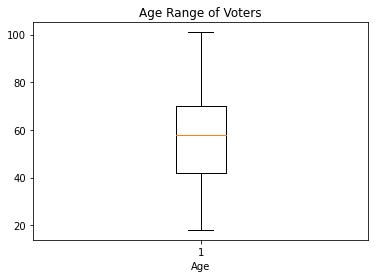

In [13]:
#Plotting age of voters
plt.boxplot(data['AGE,C,3'])
plt.title('Age Range of Voters')
plt.xlabel('Age')
plt.show()

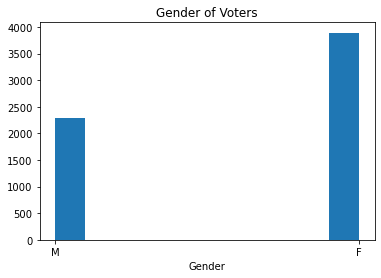

In [14]:
#Plotting gender of voters
plt.hist(data['GENDER,C,1'])
plt.title('Gender of Voters')
plt.xlabel('Gender')
plt.show()

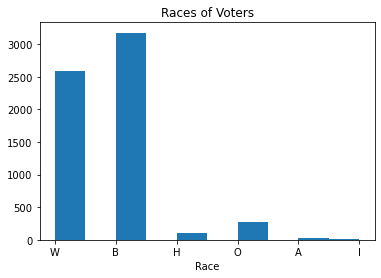

In [15]:
#Plotting race of voters
plt.hist(data['RACE,C,1'])
plt.title('Races of Voters')
plt.xlabel('Race')
plt.show()

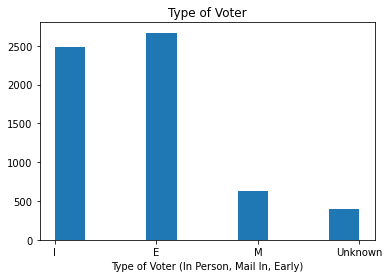

In [16]:
#Plotting voting method of voters
plt.hist(data['How they vote (in person, mail, early)'])
plt.title('Type of Voter')
plt.xlabel('Type of Voter (In Person, Mail In, Early)')
plt.show()

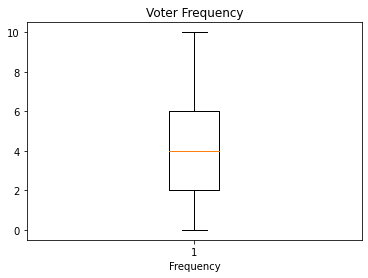

In [17]:
#Plotting voting frequency of voters
plt.boxplot(data['VOTE_FREQ,C,1'])
plt.title('Voter Frequency')
plt.xlabel('Frequency')
plt.show()

### Further data cleaning, converting object columns into numerical for models

In [18]:
#Replacing more object columns into numerical for models using dictionaries
gender_dict = {'F': 1, 'M': 2}
race_dict = {'B': 1, 'W': 2, 'H': 3, 'O': 3, 'A': 3, 'I': 3}
how_dict = {'M': 1, 'E': 2, 'I': 3, 'Unknown': 0}

data['GENDER,C,1'] = data['GENDER,C,1'].replace(gender_dict)
data['RACE,C,1'] = data['RACE,C,1'].replace(race_dict)
data['How they vote (in person, mail, early)'] = data['How they vote (in person, mail, early)'].replace(how_dict)

In [19]:
#Checking data types to ensure desired features are numerical for models
data.dtypes

HOU,C,3                                    int64
PARISH,N,2,0                               int64
TYPE,C,4                                  object
CITY,C,17                                 object
STATE,C,2                                 object
ZIP,C,5                                    int64
AGE,C,3                                    int64
GENDER,C,1                                 int64
RACE,C,1                                   int64
PARTY_ID,C,1                              object
VOTE_FREQ,C,1                              int32
PPP,C,1 (P for presidential primary)       int64
NEW,C,1                                    int64
How they vote (in person, mail, early)     int64
dtype: object

In [20]:
#Looking at correlations between features
data.corr()

,"HOU,C,3","PARISH,N,2,0","ZIP,C,5","AGE,C,3","GENDER,C,1","RACE,C,1","VOTE_FREQ,C,1","PPP,C,1 (P for presidential primary)","NEW,C,1","How they vote (in person, mail, early)"
"HOU,C,3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"PARISH,N,2,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"ZIP,C,5",NaN,NaN,1.000000,-0.028081,-0.023329,-0.110789,-0.004891,0.052369,0.000184,0.025024
"AGE,C,3",NaN,NaN,-0.028081,1.000000,0.037230,0.149859,0.438710,0.235319,-0.233340,-0.050219
"GENDER,C,1",NaN,NaN,-0.023329,0.037230,1.000000,0.012473,0.030711,-0.010321,-0.013969,-0.005250
"RACE,C,1",NaN,NaN,-0.110789,0.149859,0.012473,1.000000,0.061420,-0.045722,-0.061562,-0.087369
"VOTE_FREQ,C,1",NaN,NaN,-0.004891,0.438710,0.030711,0.061420,1.000000,0.558969,-0.156790,0.071426
"PPP,C,1 (P for presidential primary)",NaN,NaN,0.052369,0.235319,-0.010321,-0.045722,0.558969,1.000000,-0.155596,0.078441
"NEW,C,1",NaN,NaN,0.000184,-0.233340,-0.013969,-0.061562,-0.156790,-0.155596,1.000000,-0.204180
"How they vote (in person, mail, early)",NaN,NaN,0.025024,-0.050219,-0.005250,-0.087369,0.071426,0.078441,-0.204180,1.000000


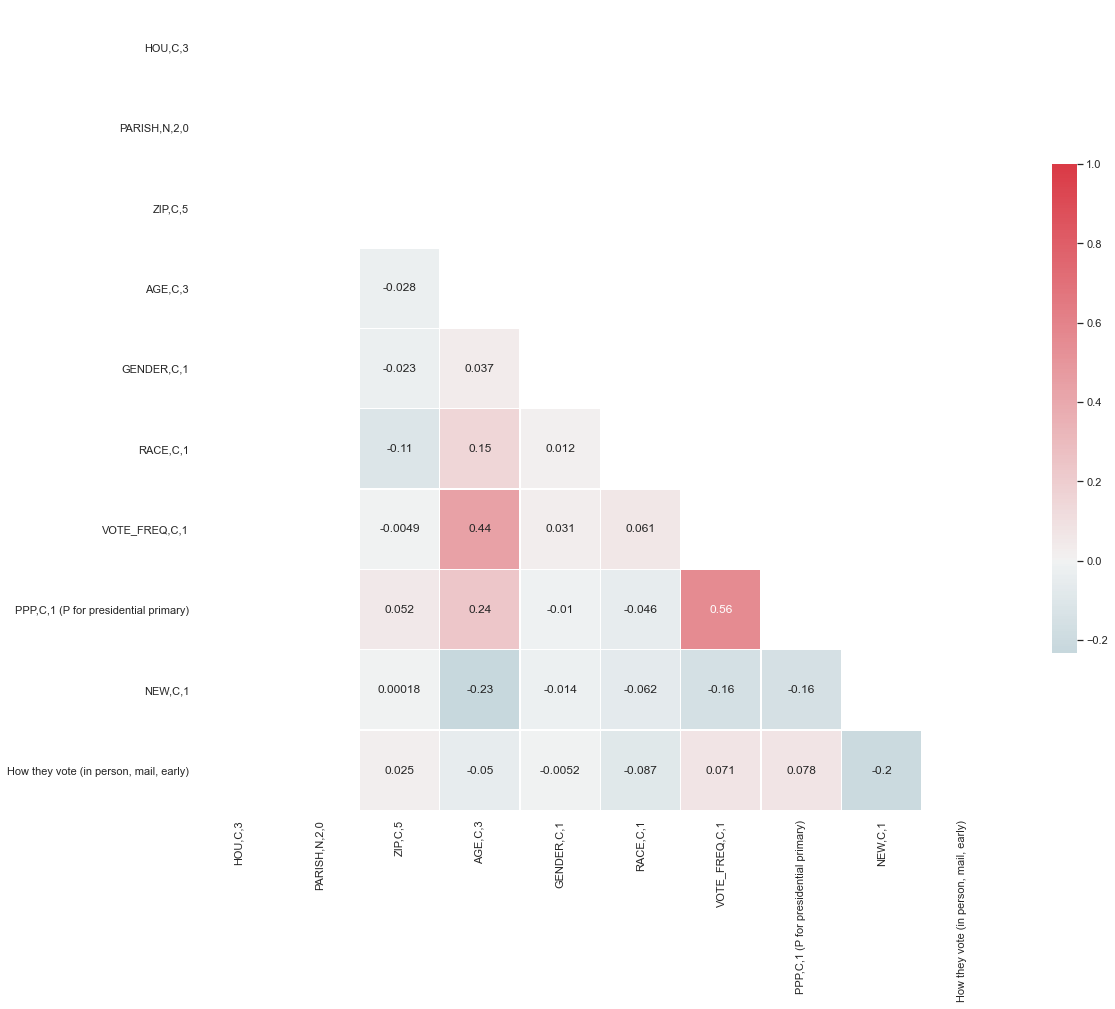

In [21]:
# Copied code from seaborn examples for correlation heat map
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

### Training the Models

In [22]:
#Using numerical columns, setting X and y and splitting into test and training sets
target_col = 'PPP,C,1 (P for presidential primary)'
numerical_cols = 'ZIP,C,5', 'AGE,C,3', 'VOTE_FREQ,C,1', 'NEW,C,1', 'GENDER,C,1', 'RACE,C,1', 'How they vote (in person, mail, early)'
feature_cols = [c for c in numerical_cols]

X =  data[feature_cols]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [23]:
#Function to calculate scores and visualizations of the scores for each model
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(float)

    prediction_int = np.round(prediction)

    accuracy_ = accuracy_score(actual, prediction_int)
    precision_ = precision_score(actual, prediction_int)
    recall_ = recall_score(actual, prediction_int)
    roc_auc_ = roc_auc_score(actual, prediction)
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction_int)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction_int)
    average_precision = average_precision_score(actual, prediction_int)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)
    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')
    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

#### Logistic Regression

In [33]:
#Fitting model with training data and scoring with test data
lin_model = LogisticRegression(solver='liblinear')
lin_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Accuracy : 0.7520 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7313 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6464 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8214                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


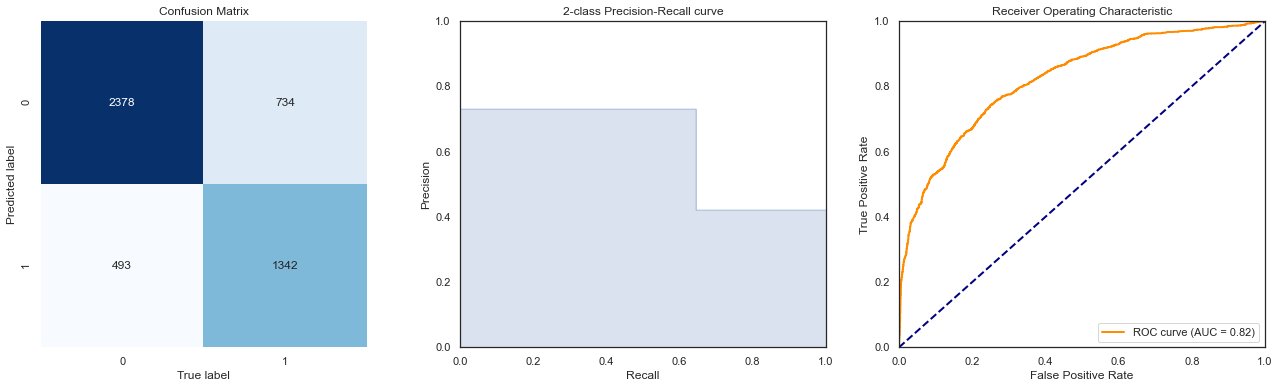

(0.7519708914493632,
 0.7313351498637602,
 0.6464354527938343,
 0.8213810418315102)

In [25]:
#Utilizing summary function to display training accuracy
y_train_pred = lin_model.predict_proba(X_train)[:,1]
show_summary_report(y_train, y_train_pred)

#### Decision Tree

Accuracy : 0.9523 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9930 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8926 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9951                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


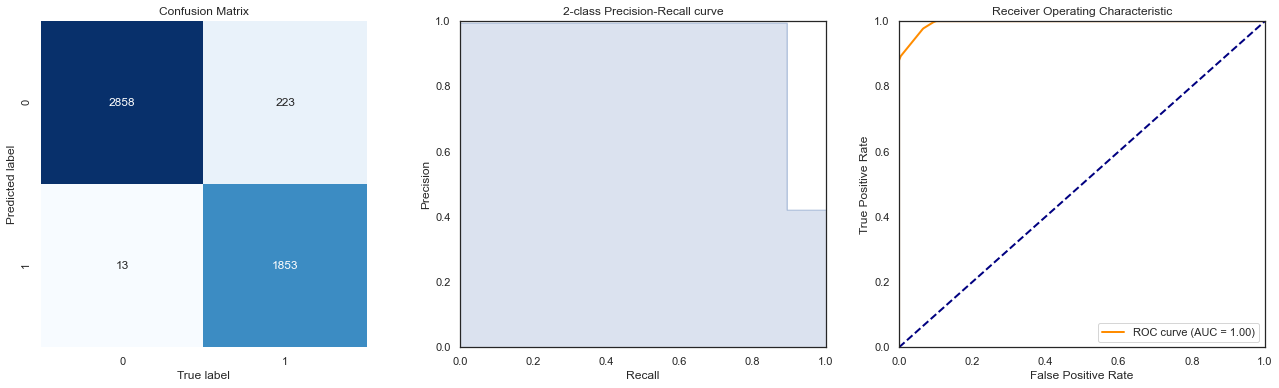

(0.9522943197897715,
 0.9930332261521972,
 0.8925818882466281,
 0.9951228113974775)

In [26]:
#Fitting model with training data and utilizing summary function to display training accuracy
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)[:,1]
show_summary_report(y_train, y_train_pred)

#### Random Forrest

Accuracy : 0.9523 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9559 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9292 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9939                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


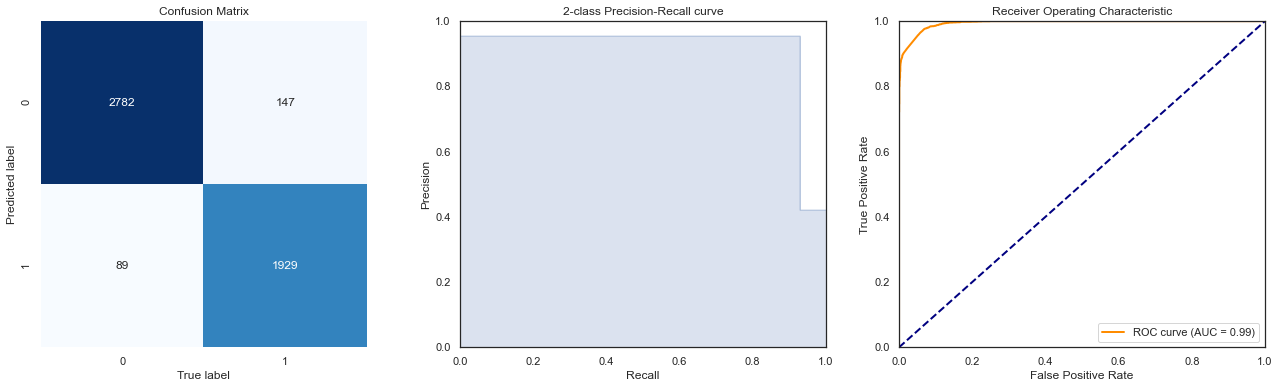

(0.9522943197897715,
 0.9558969276511398,
 0.9291907514450867,
 0.9939091768123061)

In [27]:
#Fitting model with training data and utilizing summary function to display training accuracy
model = RandomForestClassifier(random_state = 1)
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)[:,1]
show_summary_report(y_train, y_train_pred)

#### Bagging

Accuracy : 0.9521 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9545 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9302 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9940                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


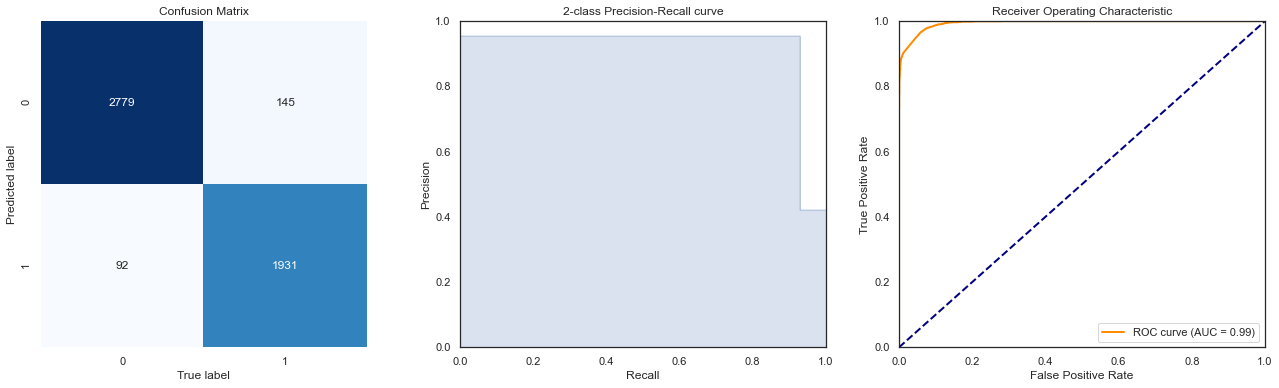

(0.9520921770770163,
 0.9545229856648542,
 0.9301541425818882,
 0.9940024623351312)

In [28]:
#Fitting model with training data and utilizing summary function to display training accuracy
cart = DecisionTreeClassifier()
bagging = BaggingClassifier(base_estimator=cart, n_estimators=100, random_state=42)
bagging.fit(X_train, y_train)
y_train_pred = bagging.predict_proba(X_train)[:,1]
show_summary_report(y_train, y_train_pred)

#### Boosting

Accuracy : 0.7732 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7738 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6493 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8400                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


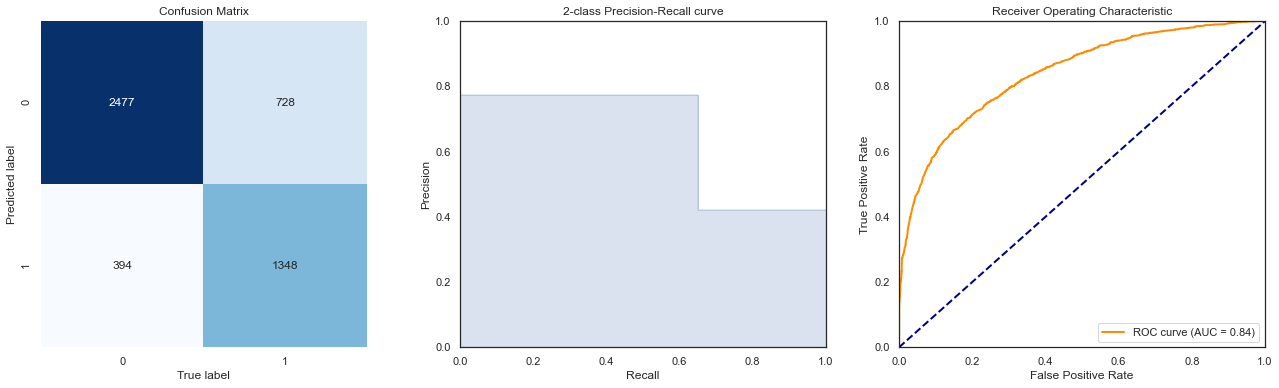

(0.7731958762886598, 0.7738231917336394, 0.649325626204239, 0.8399573604626426)

In [29]:
#Fitting model with training data and utilizing summary function to display training accuracy
boosting = AdaBoostClassifier(n_estimators=50, random_state=42)
boosting.fit(X_train, y_train)
y_train_pred = boosting.predict_proba(X_train)[:,1]
show_summary_report(y_train, y_train_pred)

#### Stacking

In [30]:
#Fitting model with training data stacking KNN, GaussianNB, and Logistic Regression
from mlxtend.classifier import StackingClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

rfc = RandomForestClassifier(n_estimators = 20, random_state = 42)
rfc.fit(X_train, y_train)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

lr = LogisticRegression()
lr.fit(X_train, y_train)

sclf = StackingClassifier(classifiers=[knn, rfc, gnb], meta_classifier=lr)
sclf.fit(X_train, y_train)

print(sclf.score(X_train, y_train))

results = cross_val_score(sclf, X_train, y_train, cv = 10)

print(results.mean())

0.9460278956943602
0.732359628675418


Accuracy : 0.9523 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9559 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9292 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9939                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


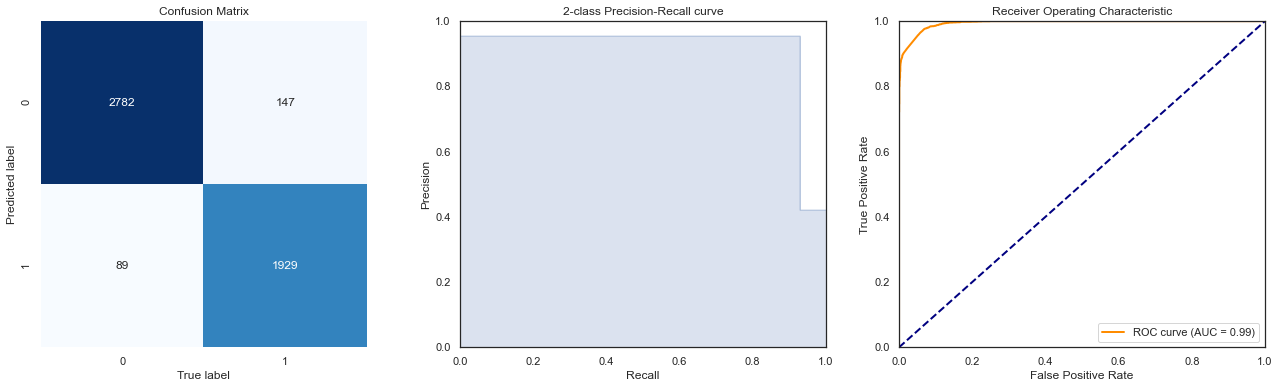

(0.9522943197897715,
 0.9558969276511398,
 0.9291907514450867,
 0.9939091768123061)

In [31]:
#Utilizing summary function to display training accuracy
y_train_pred = model.predict_proba(X_train)[:,1]
show_summary_report(y_train, y_train_pred)

### Testing the Models

*******
* KNN *
*******
Accuracy : 0.7259 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6948 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6185 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7502                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


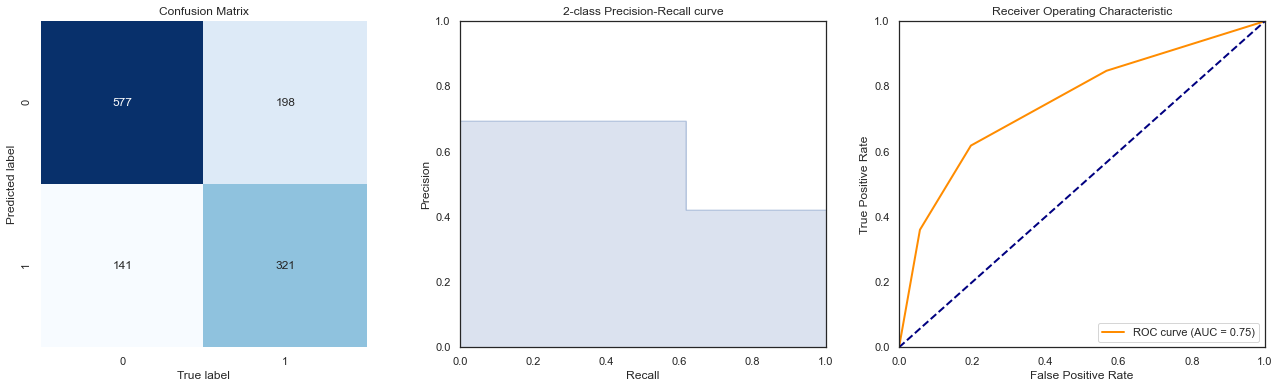


****************
* RandomForest *
****************
Accuracy : 0.7300 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6981 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6281 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7905                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


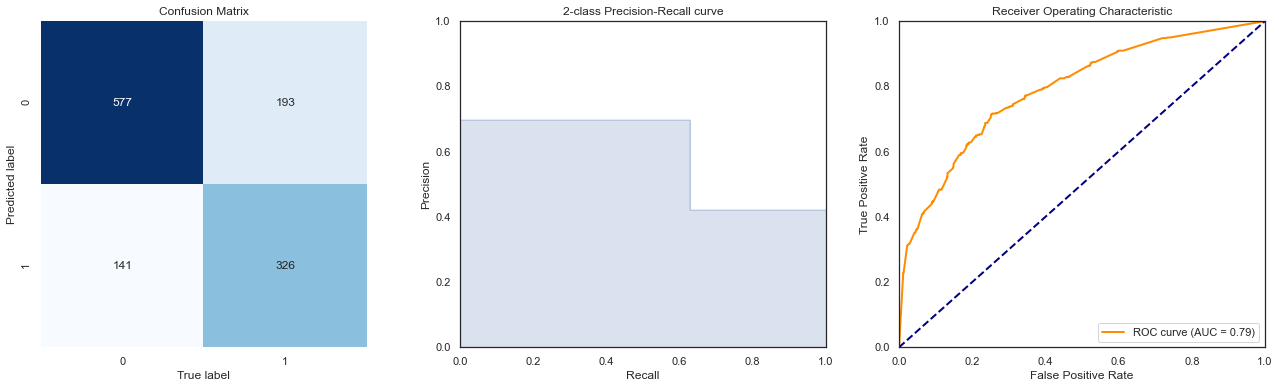


**************
* GaussianNB *
**************
Accuracy : 0.7591 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7105 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7187 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8218                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


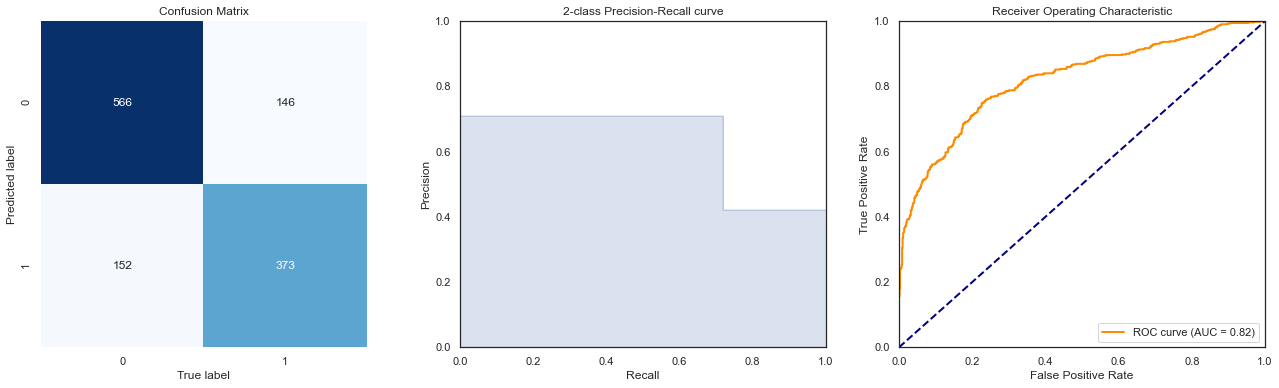


************
* Logistic *
************
Accuracy : 0.7462 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7022 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6859 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8286                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


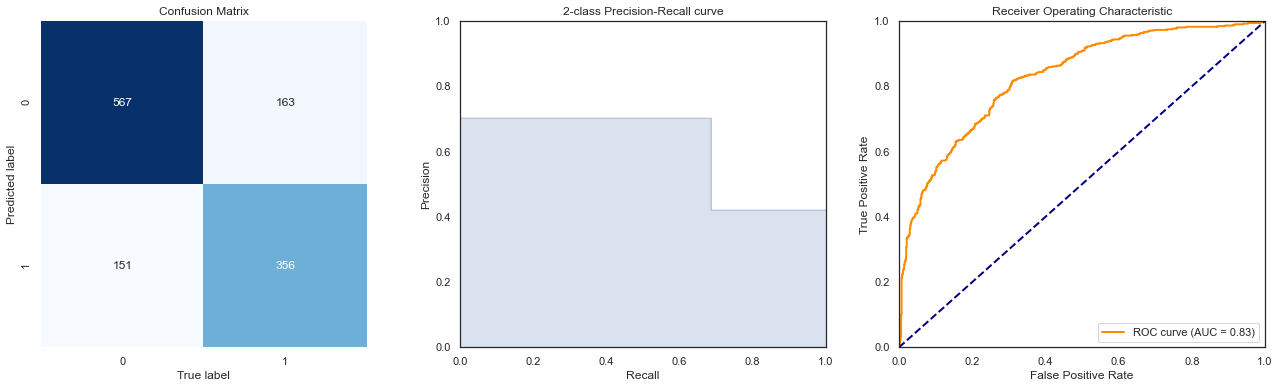


************
* Stacking *
************
Accuracy : 0.7300 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6981 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6281 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7859                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


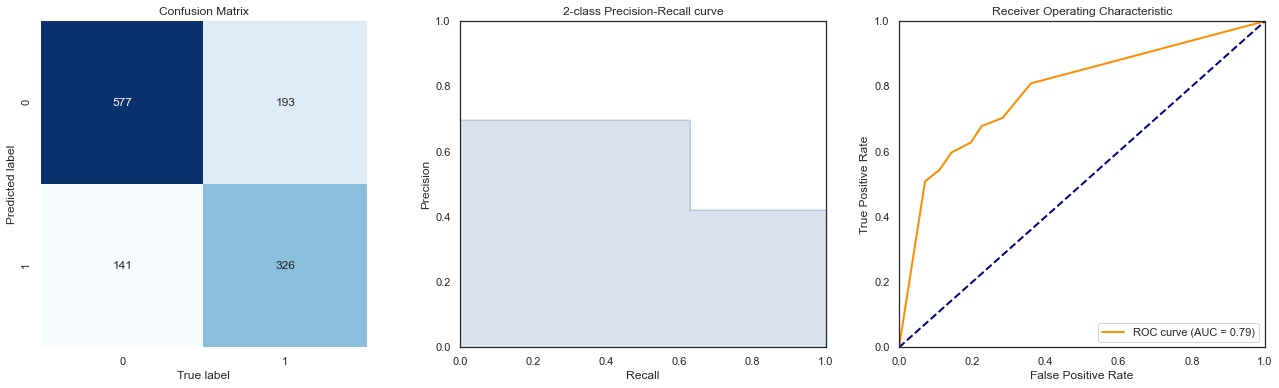


************
* Boosting *
************
Accuracy : 0.7728 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7610 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6686 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8433                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


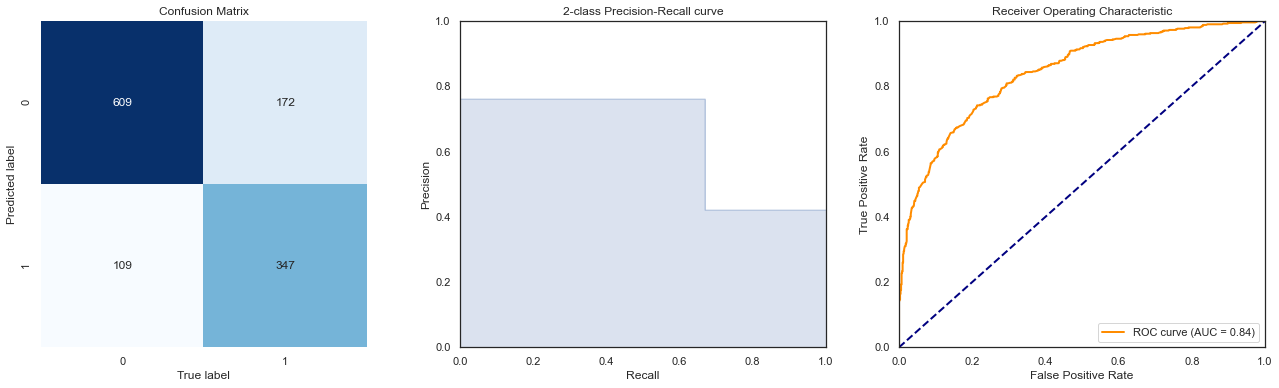


***********
* Bagging *
***********
Accuracy : 0.7389 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7094 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6397 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7889                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


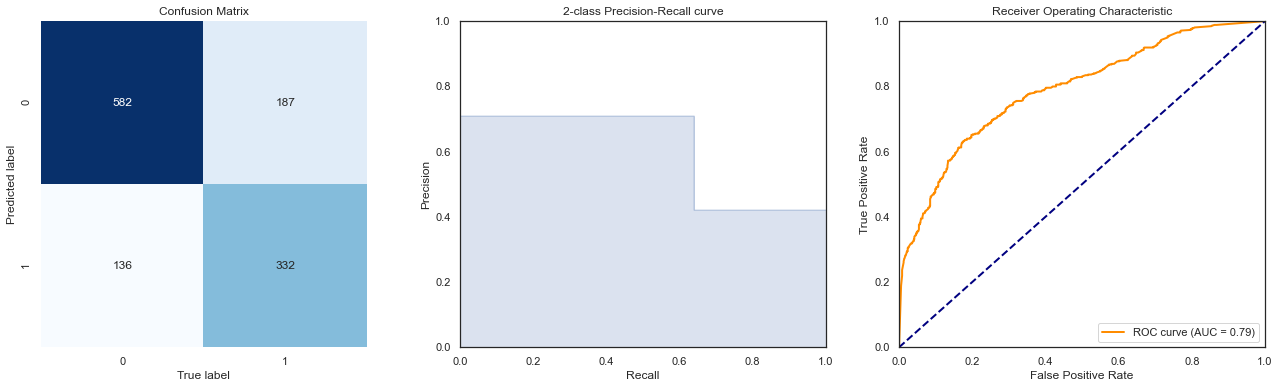

In [32]:
# Keep the results in a dataframe
results_test = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

#Using a function to look at test data in models and use summary function to display results
models = ['KNN', 'RandomForest', 'GaussianNB', 'Logistic', 'Stacking', 'Boosting', 'Bagging']
for i, m in enumerate([knn, rfc, gnb, lr, sclf, boosting, bagging]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))

    probabilities = m.predict_proba(X_test)[:,1]
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, probabilities)
    # keep the results
    results_test.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()